In [15]:
import math
import random

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/Users/harpalsahota/Library/Caches/pypoetry/virtualenvs/datascience-knowledge-base-5Tv7d-0x-py3.8/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# The Upper Confidence Bound Algorithm

## Introducing the UCB Algorithm

The algorithms we’ve presented so far have one systematic weakness: they don’t keep track of how much they know about any of the arms available to them. They pay attention only to how much reward they’ve gotten from the arms. This means that they’ll under‐ explore options whose initial experiences were not rewarding, even though they don’t have enough data to be confident about those arms. We can do better by using an algorithm that pays attention to not only what it knows, but also how much it knows UCB algorithm.

Before we describe how the UCB algorithm keeps track of how much it knows, let’s look back at the epsilon-Greedy and Softmax algorithms and take a more abstract perspective on them. Both the epsilon-Greedy algorithm and the Softmax algorithm share the following broad properties:
- The algorithm’s default choice is to select the arm that currently has the highest estimated value
- The algorithm sometimes decides to explore and chooses an option that isn’t the one that currently seems best:
    - The epsilon-Greedy algorithm explores by selecting from all of the arms completely at random. It makes one of these random exploratory decisions with probability epsilon.
    - The Softmax algorithm explores by randomly selecting from all of the available arms with probabilities that are more-or-less proportional to the estimated value of each of the arms. If the other arms are noticeably worse than the best arm, they’re chosen with very low probability. If the arms all have similar values, they’re each chosen nearly equally often.
- In order to achieve better performance by making an effort to have these two algorithms explore less over time, both algorithms can be set up to modify their basic parameters dynamically over time. We called this modification annealing.

Looking at this list, we can see how UCB can improve upon the epsilon-Greedy and Softmax algorithms: it can make decisions to explore that are driven by our confidence in the estimated value of the arms we’ve selected.

Why is it important to keep track of our confidence in the values of the arms? The reason has to do with the nature of the rewards we receive from the arms: they’re noisy. If we use our past experiences with an arm, then the estimated value of any arm is always a noisy estimate of the true return on investment we can expect from it. Because of this noise, it might just be a coincidence that Arm A seems better than Arm B; if we had more experience with both arms, we’d eventually realize that Arm B is actually better. The epsilon-Greedy and Softmax algorithms aren’t robust to this noise during their first experiences with things.

Or, to put things in more human terms, the epsilon-Greedy and Softmax algorithms are gullible. They are easily misled by a few negative experiences. Because of their use of randomness, they can make up for this later. UCB takes a very different approach. As you’ll see, UCB does not use randomness at all.

Instead, UCB avoids being gullible by requiring us to keep track of our confidence in our assessments of the estimated values of all of the arms. To do that, we need to have some metric of how much we know about each arm.

Thankfully, we already have information on hand that will give us that metric: we’ve been explicitly keeping track of the number of times we’ve pulled each arm for both of the algorithms we’ve used so far. Inside of the counts field in our epsilon-Greedy and Softmax classes, we have enough information to calculate a simple metric of our confidence in the estimated values of the various arms. We just need to find a way to take advantage of that information.

The UCB family of algorithms does just that. In fact, their focus on confidence is the source of the name UCB, which is an acronym for Upper Confidence Bounds. For this book, we’re going to focus on only one of the algorithms in the UCB family. This special case is called the UCB1 algorithm. We’ll generally refer to the UCB1 algorithm as the UCB algorithm.

_While we won’t focus on other UCB variants, we need to note that the UCB1 algorithm, unlike its siblings, makes a couple of assumptions that you may need to be cautious about. Foremost of these is the assumption that the maximum possible reward has value 1. If that’s not true in your setting, you need to rescale all of your rewards to lie between 0 and 1 before using the UCB1 algorithm we present below._

In addition to explicitly keeping track of our confidence in the estimated values of each arm, the UCB algorithm is special for two other reasons:

- UCB doesn’t use randomness at all. Unlike epsilon-Greedy or Softmax, it’s possible to know exactly how UCB will behave in any given situation. This can make it easier to reason about at times.
- UCB doesn’t have any free parameters that you need to configure before you can deploy it. This is a major improvement if you’re interested in running it in the wild, because it means that you can start to use UCB without having a clear sense of what you expect the world to behave like.

Taken together, the use of an explicit measure of confidence, the absence of unnecessary randomness and the absence of configurable parameters makes UCB very compelling. UCB is also very easy to understand, so let’s just present the algorithm and then we can continue to discuss it in more detail.

## Implementing UCB

As we did with the epsilon-Greedy and Softmax algorithms, we’ll start off by implementing a class to store all of the information that our algorithm needs to keep track of:

In [3]:
class UCB1:

    def __init__(self, counts, values):
        self.counts = counts
        self.values = values

    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)] 
        self.values = [0.0 for col in range(n_arms)]
        
    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0: 
                return arm
        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts = sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))
            ucb_values[arm] = self.values[arm] + bonus
        return ind_max(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

As you can see from this chunk of code, UCB doesn’t have any parameters beyond the absolute minimum counts and values fields that both the epsilon-Greedy and Softmax algorithms had. The reason UCB gets away without this is how it exploits the counts field.

Let’s start by focusing our attention on the `if self.counts[arm] == 0` line. What’s going on here? The UCB algorithm is using this line to insure that it has played every single arm available to it at least once. This is UCB’s clever trick for insuring that it doesn’t have a total cold start before it starts to apply its confidence-based decision rule. It’s important to keep this initialisation step in mind when you consider deploying `UCB1`: if you will only let the algorithm run for a small number of plays (say M) and you have many arms to explore (say N), it’s possible that UCB1 will just try every single arm in succession and not even make it to the end. If M < N, this is definitely going to occur. If M is close to N, you’ll still spend a lot of time just doing this initial walkthrough. Whether that is a good or bad thing is something you need to consider before using UCB.

But, if you have a lot of plays ahead of you, this initial pass through all of the arms is a very good thing. It insures that the UCB algorithm knows a little bit about all available options, which makes it very effective when there are clearly inferior arms that can be essentially ignored right from start.

Once we’ve gotten past the initial cycling through all of the available arms, UCB1’s real virtues kick in. As you can see, the `select_arm` method for UCB1 uses a special type of value that we’ve called a `ucb_value` in this code. The `ucb_value` combines the simple estimated value of each arm with a special bonus quantity, which is `math.sqrt((2 * math.log(total_counts)) / float(self.counts[arm]))`. The meaning of this bonus is worth pondering for a bit. The most basic statement that can be made about it is that it augments the estimated value of any arm with a measure of how much less we know about that arm than we know about the other arms. That claim can be confirmed by considering what happens if you ignore everything except for `math.log(to tal_counts) / float(self.counts[arm])`. If `counts[arm]` is small relative to `total_counts` for a certain arm, this term will be larger than when `counts[arm]` is large relative to `total_counts`. The effect of that is that UCB is a explicitly curious algorithm that tries to seek out the unknown.

The other factors around this core unit of curiosity are essentially rescaling terms that make UCB work properly. For those interested in more formal details, these rescaling terms allow the algorithm to define a confidence interval that has a reasonable chance of containing the true value of the arm inside of it. UCB creates its `ucb_values` by replacing every arm’s estimated value with the upper bound on the confidence interval for its value. This is why the algorithm is the `Upper Confidence Bound algorithm`.

But, setting aside issues of confidence bounds, the big idea that drives UCB is present in just dividing `math.log(total_counts))` by `float(self.counts[arm])`. As we said above, this quantity becomes a big boost in the effective value of the arm for arms that we know little about. That means that we try hard to learn about arms if we don’t know enough about them, even if they seem a little worse than the best arm. In fact, this curiosity bonus means we’ll even occasionally visit the worst of the arms we have available.

In fact, this curiosity bonus means that UCB can behave in very surprising ways. For example, consider the plot shown below of UCB’s chances of selecting the right arm at any given point in time.

This graph looks very noisy compared with the graphs we’ve shown for the epsilon- Greedy and Softmax algorithm. As we noted earlier, UCB doesn’t use any randomness when selecting arms. So where is the noise coming from? And why is it so striking compared with the randomized algorithms we described earlier?

The answer is surprising and reveals why the curiosity bonus that UCB has can behave in an non-intuitive way: the little dips you see in this graph come from UCB backped‐ aling and experimenting with inferior arms because it comes to the conclusion that it knows too little about those arms. This backpedaling matters less and less over time, but it’s always present in UCB’s behavior, which means that UCB doesn’t become a strictly greedy algorithm even if you have a huge amount of data.

In [1]:
"""
Code from notebook 3
"""
def ind_max(x):
    m = max(x)
    return x.index(m) 

class BernoulliArm():

    def __init__(self, p):
        self.p = p
        
    def __repr__(self):
        return f'<BernoulliArm p={self.p}>'

    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
        
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialise(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
        
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward
            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

In [48]:
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print(f"Best arm is {ind_max(means)}")

Best arm is 2


In [49]:
N_SIMS = 5000 # Number of simulations to run
HORIZON = 250 # Number of time points in each simulation

algo = UCB1([], [])
algo.initialise(n_arms)
results = test_algorithm(algo, arms, N_SIMS, HORIZON)

In [14]:
RESULT_INDEX = 2 # Index 2 is the selected arms

# Split the simulations into individual simulation runs
selected_arms = np.array([results[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])

# Count how often the best arm was selected then divide by the total number of simulations to obtain the probability of selecting the best arm at each time point 
# Taking sum where best_arm_probs == 2 becuase index of best arm is 2 as determined above
best_arm_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

Text(0.5, 1.0, 'Accuracy of the UCB1 Algorithm')

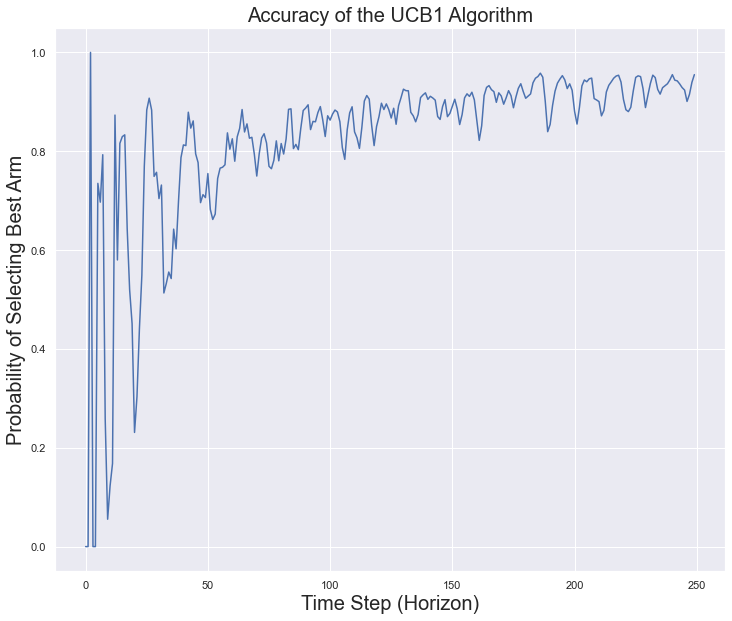

In [18]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=best_arm_probs)
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.title('Accuracy of the UCB1 Algorithm', size=20)

At first this backpedaling may seem troubling. To convince you that UCB is often very effective despite this counter-intuitive tendency to oscillate back into exploring inferior arms, we need to explicitly compare UCB with the other algorithms we’ve studied so far. This is quite easy to do, because we can simply pool all of the simulation results we’ve gathered so far and treat them like a single unit for analysis. In the next section, we walk through the results.

## Comparing Bandit Algorithms Side-by-Side

Now that we’ve implemented three different algorithms for solving the Multiarmed Bandit, it’s worth comparing them on a single task. As before, we’ve tested the algorithms using the testbed of 5 arms we’ve used in all of our examples so far.

For this set of comparisons, we’ve decided to focus on annealing versions of epsilon- Greedy and Softmax alongside UCB1. Using annealing versions of the epsilon-Greedy and Soft‐max algorithms helps to make the comparisons with UCB1 simpler by removing parameters that have to be tuned for the epsilon-Greedy and Softmax algorithms to do their best.

In the following figures you can see the results of our three standard types of analyses for this comparison test set. The figure below we’ve plotted the probability of selecting the best arm on each play by three of the algorithms we’ve used so far. Looking at this image, there are a few things that are striking:
- We can very clearly see how much noisier UCB1’s behavior looks than the epsilon- Greedy or Softmax algorithms.
- We see that the epsilon-Greedy algorithm doesn’t converge as quickly as the Softmax algorithm. This might suggest that we need to use another annealing schedule or that this testbed is one in which the Softmax algorithm is simply superior to the epsilon-Greedy algorithm.
- We see that UCB1 takes a while to catch up with the annealing Softmax algorithm, but that it does start to catch up right near the end of the plays we’ve simulated. In the exercises we encourage you to try other enviroments in which UCB1 might outperform Softmax unambigiously.
- UCB1 finds the best arm very quickly, but the backpedaling it does causes it to underperform the Softmax algorithm along most metrics.

In [21]:
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i] 
        cum_prob += prob
        if cum_prob > z:
            return i
    return len(probs) - 1

class AnnealingSoftmax:

    def __init__(self, counts, values):
        self.counts = counts 
        self.values = values

    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

    def select_arm(self):
        t = sum(self.counts) + 1
        temperature = 1 / math.log(t + 0.0000001)        
        
        z = sum([math.exp(v / temperature) for v in self.values])
        probs = [math.exp(v / temperature) / z for v in self.values] 
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward 
        self.values[chosen_arm] = new_value
        
        
# def ind_max(x):
#     m = max(x)
#     return x.index(m) 

# def select_arm(self):
#     if random.random() > self.epsilon:
#         return ind_max(self.values) 
#     else:
#         return random.randrange(len(self.values))

class AnnealingEpsilonGreedy:
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        
    def initialise(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        
    def ind_max(self, x):
        m = max(x)
        return x.index(m) 

    def select_arm(self):
        t = sum(self.counts) + 1
        eps = 1 / np.log(t + 0.0000001)
        if random.random() > eps:
            return self.ind_max(self.values) 
        else:
            return random.randrange(len(self.values))
        
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [22]:
N_SIMS = 5000 # Number of simulations to run
HORIZON = 250 # Number of time points in each simulation

algo = UCB1([], [])
algo.initialise(n_arms)
results_ucb = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingEpsilonGreedy([], [])
algo.initialise(n_arms)
results_aeg = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingSoftmax([], [])
algo.initialise(n_arms)
results_asm = test_algorithm(algo, arms, N_SIMS, HORIZON)

In [23]:
RESULT_INDEX = 2 # Index 2 is the selected arms

selected_arms = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_ucb_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

selected_arms = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_aeg_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

selected_arms = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_asm_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

Text(0.5, 1.0, 'Accuracy of Different Algorithm')

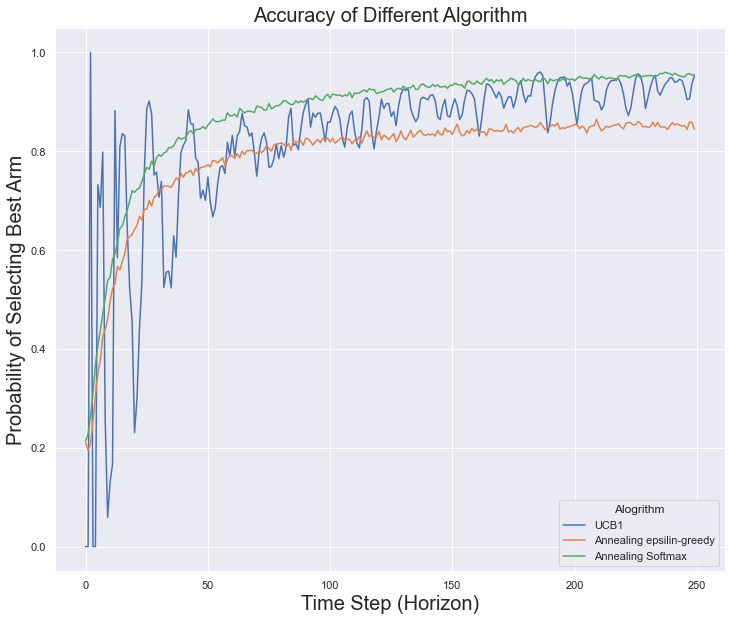

In [27]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=best_arm_ucb_probs, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=best_arm_aeg_probs, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=best_arm_asm_probs, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Accuracy of Different Algorithm', size=20)

Following plots look at the average and cumulative rewards

In [26]:
RESULT_INDEX = 3 # Index 3 is the rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_mean_rewards = np.mean(arm_rewards, axis=0)

Text(0.5, 1.0, 'Performance of Different Algorithms')

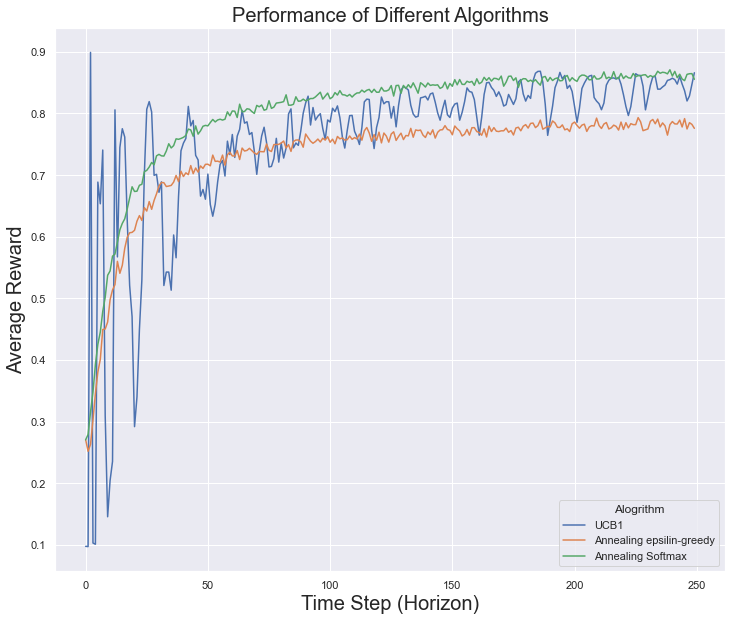

In [29]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_mean_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_mean_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_mean_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Average Reward', size=20)
plt.legend(title='Alogrithm')
plt.title('Performance of Different Algorithms', size=20)

In [30]:
RESULT_INDEX = 4 # Index 4 is the cumulative rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_cum_rewards = np.mean(arm_rewards, axis=0)

Text(0.5, 1.0, 'Cumulative Reward of Different Algorithms')

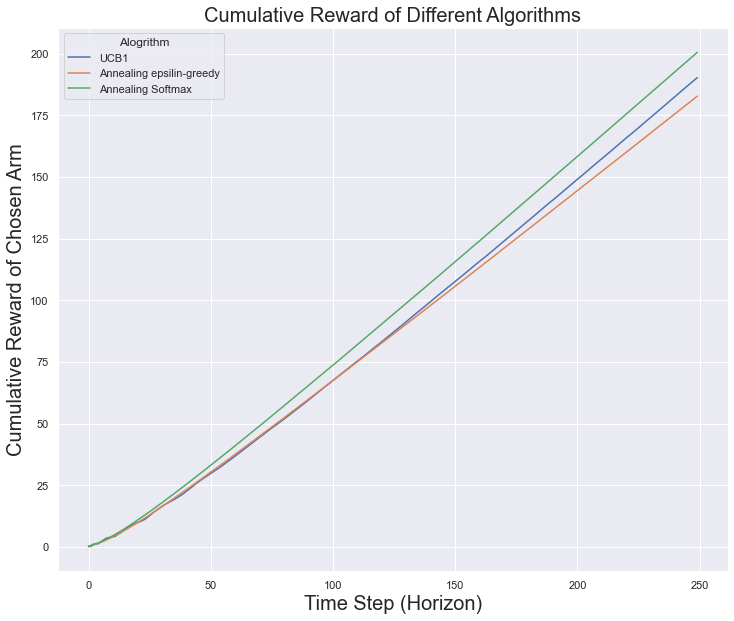

In [31]:
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_cum_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_cum_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_cum_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Cumulative Reward of Chosen Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Cumulative Reward of Different Algorithms', size=20)

## Run for 1000 Trials

Instead of 250 trials lets run for 1000 trials

In [51]:
N_SIMS = 5000 # Number of simulations to run
HORIZON = 1000 # Number of time points in each simulation

algo = UCB1([], [])
algo.initialise(n_arms)
results_ucb = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingEpsilonGreedy([], [])
algo.initialise(n_arms)
results_aeg = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingSoftmax([], [])
algo.initialise(n_arms)
results_asm = test_algorithm(algo, arms, N_SIMS, HORIZON)

Text(0.5, 1.0, 'Accuracy of Different Algorithm')

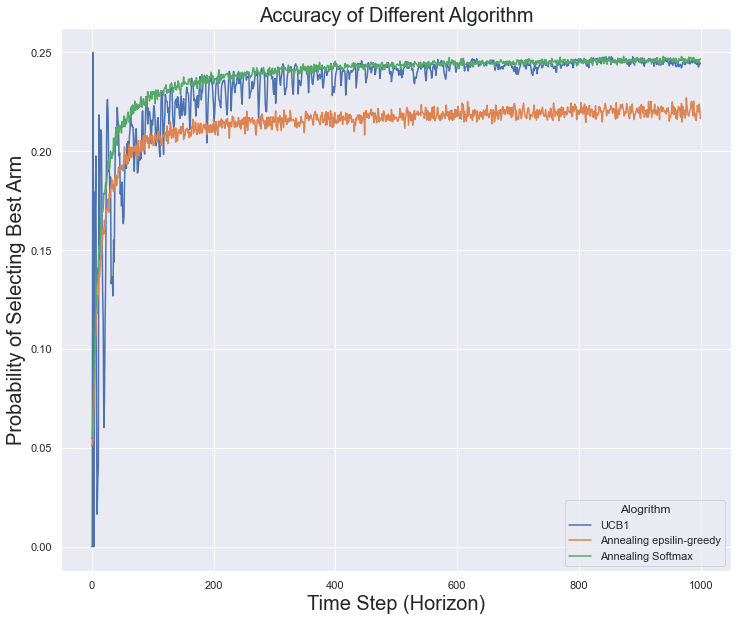

In [52]:
RESULT_INDEX = 2 # Index 2 is the selected arms

selected_arms = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_ucb_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

selected_arms = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_aeg_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

selected_arms = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_asm_probs = np.sum(selected_arms == 2, axis=0) / N_SIMS

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=best_arm_ucb_probs, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=best_arm_aeg_probs, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=best_arm_asm_probs, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Accuracy of Different Algorithm', size=20)

Text(0.5, 1.0, 'Performance of Different Algorithms')

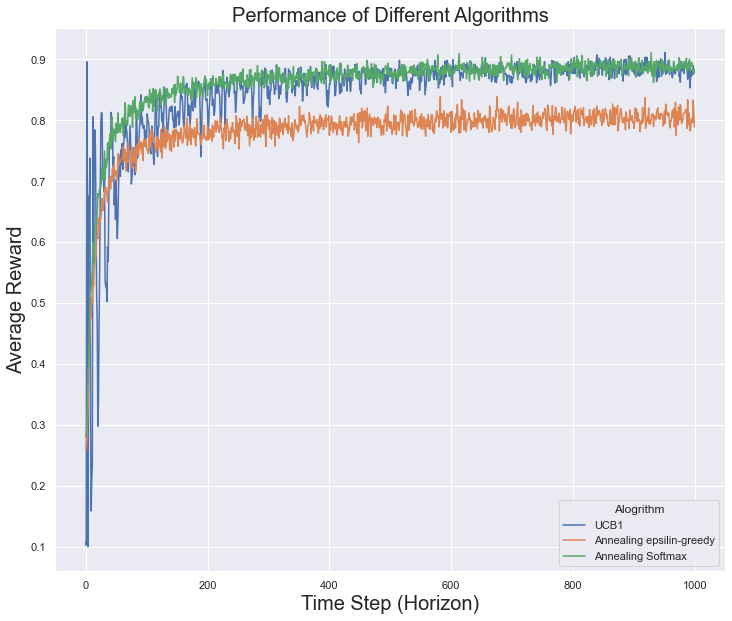

In [53]:
RESULT_INDEX = 3 # Index 3 is the rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_mean_rewards = np.mean(arm_rewards, axis=0)

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_mean_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_mean_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_mean_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Average Reward', size=20)
plt.legend(title='Alogrithm')
plt.title('Performance of Different Algorithms', size=20)

Text(0.5, 1.0, 'Cumulative Reward of Different Algorithms')

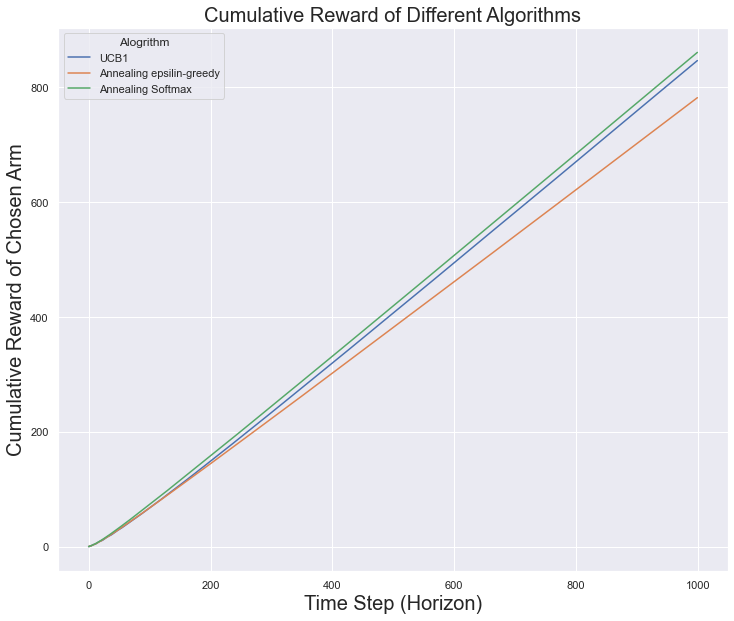

In [54]:
RESULT_INDEX = 4 # Index 4 is the cumulative rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_cum_rewards = np.mean(arm_rewards, axis=0)

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_cum_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_cum_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_cum_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Cumulative Reward of Chosen Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Cumulative Reward of Different Algorithms', size=20)

Increasing the number trials shows how the UCB1 converges to where the softmax algorithm is

## 100 Arms and 1000 Trials

Let's increase the numbers of arms from 5 to 100

In [55]:
random.seed(1)
means = [0.1 for _ in range(99)]
means.append(0.9)
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print(f"Best arm is {ind_max(means)}")

Best arm is 23


In [56]:
len(means) # Number of arms

100

In [57]:
N_SIMS = 5000 # Number of simulations to run
HORIZON = 1000 # Number of time points in each simulation

algo = UCB1([], [])
algo.initialise(n_arms)
results_ucb = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingEpsilonGreedy([], [])
algo.initialise(n_arms)
results_aeg = test_algorithm(algo, arms, N_SIMS, HORIZON)

algo = AnnealingSoftmax([], [])
algo.initialise(n_arms)
results_asm = test_algorithm(algo, arms, N_SIMS, HORIZON)

Text(0.5, 1.0, 'Accuracy of Different Algorithm')

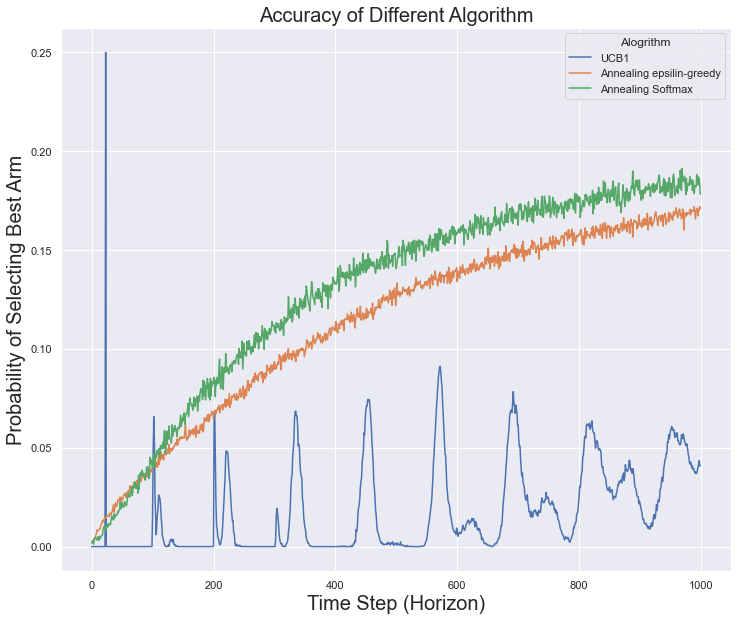

In [58]:
RESULT_INDEX = 2 # Index 2 is the selected arms
BEST_ARM = ind_max(means)

selected_arms = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_ucb_probs = np.sum(selected_arms == BEST_ARM, axis=0) / N_SIMS

selected_arms = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_aeg_probs = np.sum(selected_arms == BEST_ARM, axis=0) / N_SIMS

selected_arms = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
best_arm_asm_probs = np.sum(selected_arms == BEST_ARM, axis=0) / N_SIMS

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=best_arm_ucb_probs, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=best_arm_aeg_probs, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=best_arm_asm_probs, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Probability of Selecting Best Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Accuracy of Different Algorithm', size=20)

Text(0.5, 1.0, 'Performance of Different Algorithms')

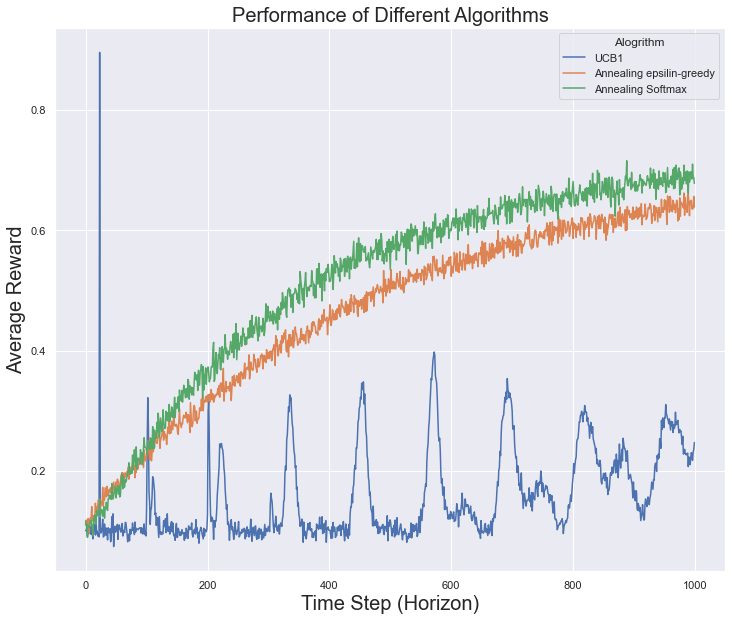

In [59]:
RESULT_INDEX = 3 # Index 3 is the rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_mean_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_mean_rewards = np.mean(arm_rewards, axis=0)

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_mean_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_mean_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_mean_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Average Reward', size=20)
plt.legend(title='Alogrithm')
plt.title('Performance of Different Algorithms', size=20)

Text(0.5, 1.0, 'Cumulative Reward of Different Algorithms')

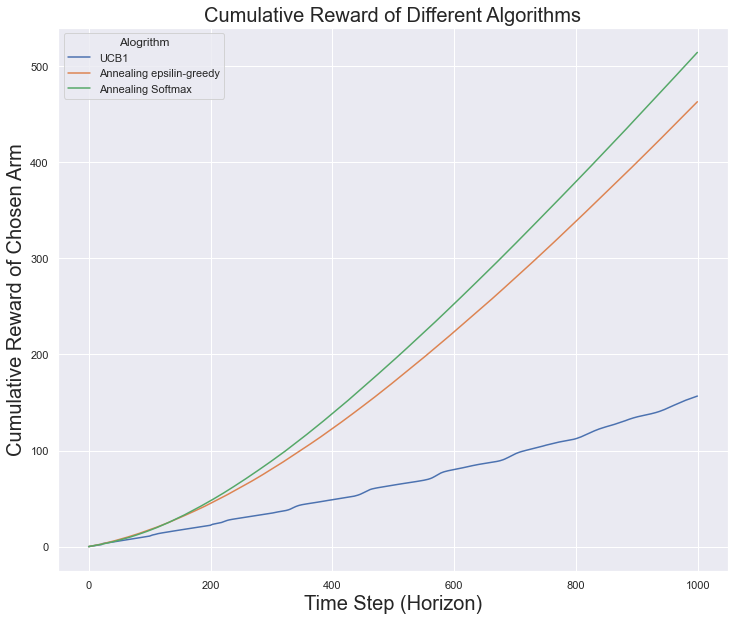

In [60]:
RESULT_INDEX = 4 # Index 4 is the cumulative rewards

arm_rewards = np.array([results_ucb[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
ucb_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_aeg[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
aeg_cum_rewards = np.mean(arm_rewards, axis=0)

arm_rewards = np.array([results_asm[RESULT_INDEX][i:i+HORIZON] for i in range(0, len(results[RESULT_INDEX]), HORIZON)])
asm_cum_rewards = np.mean(arm_rewards, axis=0)

sns.set_style('darkgrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(12, 10)})
sns.lineplot(x=range(0, HORIZON), y=ucb_cum_rewards, label='UCB1')
sns.lineplot(x=range(0, HORIZON), y=aeg_cum_rewards, label='Annealing epsilin-greedy')
sns.lineplot(x=range(0, HORIZON), y=asm_cum_rewards, label='Annealing Softmax')
plt.xlabel('Time Step (Horizon)', size=20)
plt.ylabel('Cumulative Reward of Chosen Arm', size=20)
plt.legend(title='Alogrithm')
plt.title('Cumulative Reward of Different Algorithms', size=20)

Wow, UCB1 is significantly impacted by the number of arms because each arm needs to be explored it will take a longer time to converge!